In [44]:
import os
import sys
import re

src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)
data_dir = os.path.join(os.getcwd(), '..', 'data')

# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import joblib 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA 
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns

import etl
import pipe

# magic word for producing visualizations in notebook
%matplotlib inline

In [6]:
azdiad_path = os.path.join(data_dir,'01_preprocessed/','azdiad.pkl')
azdiad = pd.read_pickle(azdiad_path) 
customer_path = os.path.join(data_dir,'01_preprocessed/','customers.pkl')
customers = pd.read_pickle(customer_path)  
data_dict_path = os.path.join(data_dir,'01_preprocessed/','data_dictionary_full.xlsx')
data_dict = pd.read_excel(data_dict_path, index_col=0)

# now done already in function
#customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].map(lambda x: 1 if x == 'W' else 0)
#azdiad['OST_WEST_KZ'] = azdiad['OST_WEST_KZ'].map(lambda x: 1 if x == 'W' else 0)

In [11]:
col_trans = pipe.define_pipeline(data_dict)
col_trans.fit(azdiad)
azdiad_trans = col_trans.transform(azdiad)

The next step is to fit a PCA to the the data. After fitting the PCA it is necessary to  find a reasonable amount of components which describe most of variance the data. This is done visually.

In [12]:
pca = PCA()
pca.fit(azdiad_trans)

PCA()

In the following graph you can see that the share of explained variance drops visually around 230 components. That is the number of components I am going to use. 

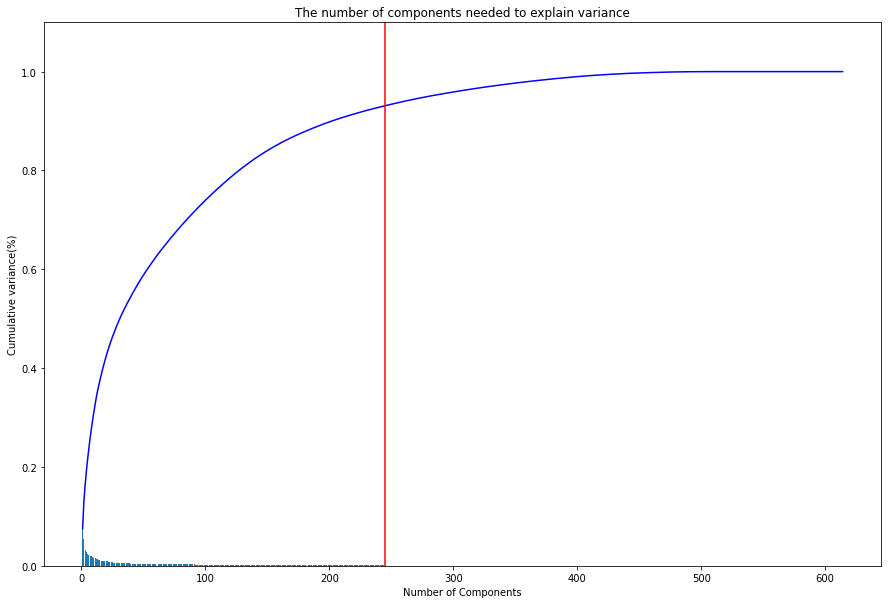

In [18]:
#fig, ax = plt.subplots()

plt.figure(figsize=(15, 10))

xi = np.arange(1,len(pca.explained_variance_)+1,step=1)
y = np.cumsum(pca.explained_variance_ratio_)
y2 = pca.explained_variance_ratio_

plt.ylim(0,1.1)
plt.plot(xi,y,linestyle='-',color='b')

plt.xlabel('Number of Components')
#plt.xticks(xi)
plt.ylabel('Cumulative variance(%)')
plt.title('The number of components needed to explain variance')

plt.bar(xi,y2)

#plt.axhline(y=0.95,color='r',linestyle='-')
plt.axvline(x=245,color='r',linestyle='-')

components_path = os.path.join(data_dir,'99_plots','components.png')
plt.savefig(components_path,bbox_inches = 'tight')

plt.show()

In [19]:
pca_n245 = PCA(n_components=245)
pca_n245.fit(azdiad_trans)

PCA(n_components=245)

The following shows the percentage of variance explained by each of the first 20 components

In [20]:
np.round(pca.explained_variance_ratio_,2)[0:20]

array([0.07, 0.05, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

To get a feeling for what influences the individual components most: 

In [21]:
cat_vars = pipe.get_attr_by_type('categorical',data_dict)
cat_vars_ohe = col_trans.transformers_[0][1]['one_hot'].get_feature_names(cat_vars)
num_vars = pipe.get_attr_by_type('numeric',data_dict)
bin_vars = pipe.get_attr_by_type('binary',data_dict)
all_vars = np.concatenate((cat_vars_ohe ,num_vars,bin_vars))

In [22]:
def var_imp_for_comp(values_component,sorting_index,all_vars=all_vars,n_vars=5):
    key = all_vars[sorting_index][0:n_vars] # var name
    value = np.round(values_component[sorting_index],3)[0:n_vars] # importance of variable
    var_imp_dict = dict(zip(key, value)) 
    
    return var_imp_dict

for comp in range(5):
    values_component_i = pca_n245.components_[comp,:]

    min_sort = np.argsort(values_component_i)
    max_sort = min_sort[::-1]

    var_imp_dict_min = var_imp_for_comp(values_component_i,min_sort)
    var_imp_dict_max = var_imp_for_comp(values_component_i,max_sort)
    
    '''
    key_max = all_vars[max_sort][0:5]
    value_max = np.round(values_component_i[max_sort],3)[0:5]
    dict_max = dict(zip(key_max, value_max)) 

    key_min = all_vars[min_sort][0:5]
    value_min = np.round(values_component_i[min_sort],3)[0:5]
    dict_min = dict(zip(key_min, value_min)) 
    '''
    
    print('For component {} the most important positive features are the following:  \n {}'.format(comp,var_imp_dict_max))
    print('For component {} the most important negative features are the following:  \n {}'.format(comp,var_imp_dict_min))
    print('\n')

For component 0 the most important positive features are the following:  
 {'PLZ8_ANTG3': 0.163, 'KBA13_ANTG3': 0.163, 'KBA13_ANTG4': 0.16, 'PLZ8_ANTG4': 0.158, 'KBA13_BAUMAX': 0.152}
For component 0 the most important negative features are the following:  
 {'PLZ8_ANTG1': -0.166, 'KBA13_ANTG1': -0.165, 'MOBI_REGIO': -0.159, 'KBA05_ANTG1': -0.147, 'KBA13_AUTOQUOTE': -0.146}


For component 1 the most important positive features are the following:  
 {'KBA13_HERST_BMW_BENZ': 0.19, 'KBA13_SEG_OBEREMITTELKLASSE': 0.163, 'KBA13_MERCEDES': 0.16, 'KBA13_BMW': 0.159, 'KBA13_SITZE_4': 0.148}
For component 1 the most important negative features are the following:  
 {'KBA13_SITZE_5': -0.15, 'KBA13_KMH_140_210': -0.138, 'KBA13_SEG_KLEINWAGEN': -0.136, 'KBA13_KMH_180': -0.125, 'KBA13_HALTER_20': -0.123}


For component 2 the most important positive features are the following:  
 {'ANZ_PERSONEN': 0.145, 'D19_SONSTIGE': 0.145, 'D19_BUCH_CD': 0.143, 'D19_TECHNIK': 0.14, 'D19_VOLLSORTIMENT': 0.139}
F

The next step is to calculate the Within-Cluster-Sum of Squared Errors for different cluster sizes. The Squared Error for each data point is the square of the distance of the point from its representation to its predicted cluster center. The Euclidean distance is used as the distance measure. 

In [23]:
azdiad_pca = pca_n245.transform(azdiad_trans)

In [28]:
data=azdiad_pca
kmax=25
verbose=True

In [29]:
sse = []
for k in range(1, kmax+1):
    kmeans = MiniBatchKMeans(n_clusters = k).fit(data)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(data)
    curr_sse = 0

    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(data)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (data[i, 0] - curr_center[0]) ** 2 + (data[i, 1] - curr_center[1]) ** 2

    sse.append(curr_sse)
    if verbose == True:
        print('SSE for K = {} is {}'.format(k,curr_sse))


SSE for K = 1 is 24788383.210823845
SSE for K = 2 is 15323745.619818274
SSE for K = 3 is 15474205.501651242
SSE for K = 4 is 11208146.222978631
SSE for K = 5 is 7890314.058847263
SSE for K = 6 is 8217347.751949398
SSE for K = 7 is 8987697.443091227
SSE for K = 8 is 7129540.145204675
SSE for K = 9 is 8150186.331326922
SSE for K = 10 is 6598178.190652998
SSE for K = 11 is 6174096.8012656765
SSE for K = 12 is 6419210.089146103
SSE for K = 13 is 6896763.016139715
SSE for K = 14 is 6559495.911880361
SSE for K = 15 is 5850790.926601316
SSE for K = 16 is 6133319.757556781
SSE for K = 17 is 6523678.73026966
SSE for K = 18 is 5897637.728362301
SSE for K = 19 is 5992582.8009639
SSE for K = 20 is 6013375.041510217
SSE for K = 21 is 5752118.324583605
SSE for K = 22 is 5843931.283474458
SSE for K = 23 is 5791110.540977775
SSE for K = 24 is 6383851.273631999
SSE for K = 25 is 5861940.520302365


In [ ]:
sse = calculate_WSS(azdiad_pca,25)

The next step is to determine the optimal number of clusters by comparing different cluster numbers visually. A good size seems to be 7. From a 8 clusters on the WSS flucuates a lot and does not really lower much much. 

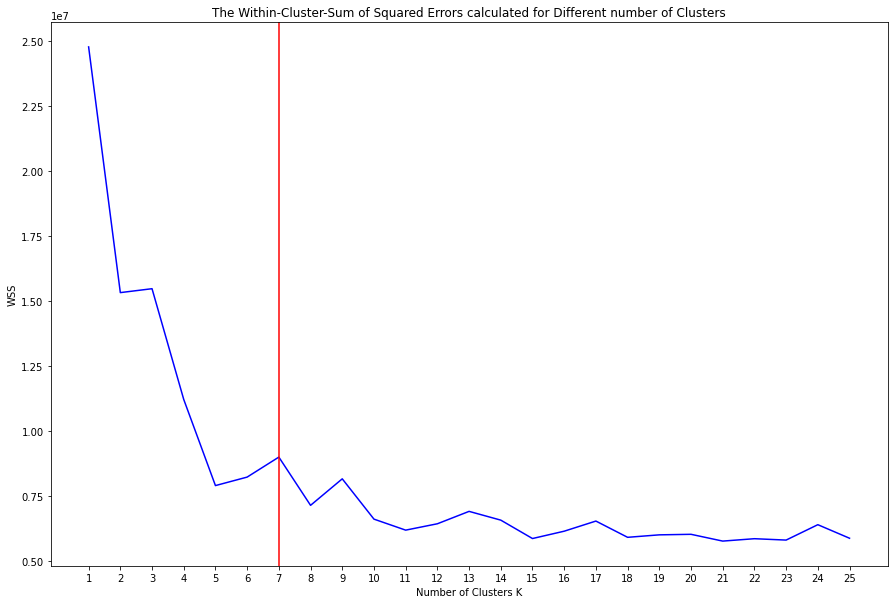

In [30]:
kmax = 25
x = range(1, kmax+1)
y = sse

plt.figure(figsize=(15, 10))

plt.plot(x,y,linestyle='-',color='b')

plt.xticks(x)
plt.xlabel('Number of Clusters K')
plt.ylabel('WSS')
plt.title('The Within-Cluster-Sum of Squared Errors calculated for Different number of Clusters')

plt.axvline(x=7,color='r',linestyle='-')

cluster_number_path = os.path.join(data_dir,'99_plots','cluster_number.png')
plt.savefig(cluster_number_path,bbox_inches = 'tight')

plt.show()

Now after having identified the steps to get different and the parameters which are used in each step, I going to bundle all steps in a pipeline. This pipeline is then fitted on the azdiad data and afterwards 

In [31]:
col_trans

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=99,
                                                                strategy='constant')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 array(['AKT_DAT_KL', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'DSL_FLAG',
       'FINANZ_ANLEGER'...
       'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT',
       'SEMIO_LUST', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT',
       'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT',
       'VK_DISTANZ', 'WOHNDAUER_2008', 'WOHNLAGE', 'ALTERSKATEGORIE_GROB'],
      dtype=object)),
                                ('binary',


In [32]:
col_trans = pipe.define_pipeline(data_dict)
cluster_pipeline = Pipeline(steps=[
    ('transform',col_trans),
    ('pca',PCA(n_components=245)),
    ('kmeans',MiniBatchKMeans(n_clusters=7))
])

In [33]:
cluster_pipeline.fit(azdiad)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=99,
                                                                                 strategy='constant')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['AKT_DAT_KL', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6...
       'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT',
       'VK_DISTANZ', 'WOHNDAUER_2008', 'WOHNLAGE', 'ALTERSKATEGORIE_GROB'],
      dtype=object)),
                                                 ('binary'

save the Cluster pipeline here

In [39]:
cluster_pipeline_path = os.path.join(data_dir,'02_models/','cluster_pipeline.pkl')
joblib.dump(cluster_pipeline, cluster_pipeline_path) 

['/Users/matthiaslenfers/code/arvato_capstone/notebooks/../data/02_models/cluster_pipeline.pkl']

In [34]:
azdiad_preds = cluster_pipeline.predict(azdiad)
customers_preds = cluster_pipeline.predict(customers)

The next step is to compare the relation of people in the different clusters: 

In [35]:
clusters_azdiad = pd.value_counts(azdiad_preds) / len(azdiad_preds)
clusters_azdiad = pd.DataFrame({'Relation': clusters_azdiad}).sort_index().reset_index().rename(columns = {'index': 'Cluster'})

clusters_customers = pd.value_counts(customers_preds) / len(customers_preds)
clusters_customers = pd.DataFrame({'Relation': clusters_customers}).sort_index().reset_index().rename(columns = {'index': 'Cluster'})





bar plot of difference in clusters

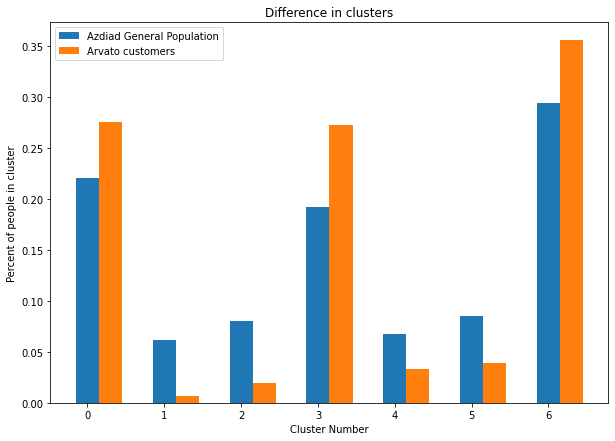

In [54]:
plt.figure(figsize=(10, 7))

width=0.3
plt.bar(clusters_azdiad['Cluster'] ,clusters_azdiad['Relation'],label='Azdiad General Population',align='center',width=width)
plt.bar(clusters_customers['Cluster'] + width,clusters_customers['Relation'],label='Arvato customers',align='center',width=width)

plt.xlabel('Cluster Number')
plt.ylabel('Percent of people in cluster')
plt.title('Difference in clusters')

# Finding the best position for legends and putting it
plt.legend(loc='best')

cluster_difference_bar_path = os.path.join(data_dir,'99_plots','cluster_difference_bar.png')
plt.savefig(cluster_difference_bar_path,bbox_inches = 'tight')


plt.show()



waterflow difference in arvato customers and german population

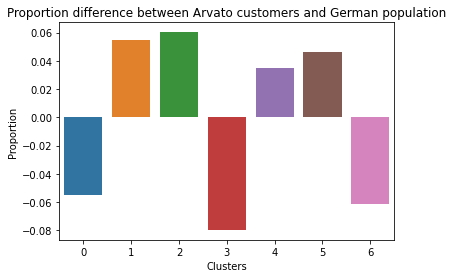

In [55]:
diff_ratio_clusters = clusters_azdiad['Relation'] - clusters_customers['Relation']
cluster_index = clusters_azdiad['Cluster']
bar_width = 0.35
fig, ax = plt.subplots()

ax = sns.barplot(x = cluster_index, y = diff_ratio_clusters)
ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion')
ax.set_title('Proportion difference between Arvato customers and German population')

cluster_difference_path = os.path.join(data_dir,'99_plots','cluster_difference.png')
plt.savefig(cluster_difference_path,bbox_inches = 'tight')



You can see that in the first graphic that the clusters 1 and 2 appear almost only in the General population and only very few Arvato customers find themselves there. Arvato customers generally tend to be more in clusters 0, 3 and 6. 


In the following I get the results of the cluster centers for the different variables. Therefore the PCA results have to inverse transformed and for the numeric variables the standardization has also to be reversed. 

In [162]:
cl_comp_df = pipe.get_cluster_comp_df(cluster_pipeline,all_vars,num_vars)

In [165]:
pd.set_option('display.max_rows', None)



In [166]:
cl_comp_df[cl_comp_df.index.isin(num_vars)]

Cluster,0,1,2,3,4,5,6
Attribute,,,,,,,
ALTERSKATEGORIE_GROB,3.300857,2.007899,2.339153,2.435323,3.343599,3.012346,2.638350
ANZ_HAUSHALTE_AKTIV,2.940399,24.552934,15.819101,2.792368,13.894697,2.496306,10.489983
ANZ_HH_TITEL,0.014898,0.017893,0.068806,0.017893,0.095760,-0.000076,0.047842
ANZ_KINDER,0.107608,0.054434,0.146280,0.291300,0.015762,0.126944,0.073770
ANZ_PERSONEN,1.679531,1.286096,1.510916,2.488881,1.567121,1.825663,1.308578
ANZ_STATISTISCHE_HAUSHALTE,2.779927,21.808459,14.385982,2.510019,12.901486,2.510019,9.392679
ANZ_TITEL,0.003826,0.000523,-0.000137,0.014393,-0.000137,0.000523,0.001844
ARBEIT,2.463602,3.496144,4.055043,2.927772,3.827694,3.297214,3.306687
BALLRAUM,4.824945,3.327141,3.743197,4.450494,3.493563,6.093919,3.576775


Comparing the cluster centers you can see, that people in clusters 1 and 2 are a bit younger than the rest of the clusters (ALTERSKATEGORIE). People inside clusters 0,3 and 6 are some times a bit older. 

Generally it is quite difficult to make a meaningful differenciation between the clusters as there are still so many variables and there arent. When the goal is to really compare the groups I would probably try to
When the goal is more to automatically identify who to target, a classification approach will probably make more sense. 
